In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Read in the file with pandas
def readInWL(filenameIn):
    dataIn = pd.read_csv(filenameIn, index_col=0, parse_dates=False,
                        usecols=['DATE_TIME','A1_WL_VALUE_MSL','A1_WL_SIGMA','B1_WL_VALUE_MSL','VER_WL_VALUE_MSL','PRED_WL_VALUE_MSL']
                        )
    dataIn.columns = ['primary','sigma','backup','verified','prediction']
    dataIn.index.name ='time'
    dataIn = dataIn.apply(pd.to_numeric, errors='coerce')
    dataIn.head()
    return dataIn

In [3]:
def initial_data_prep(dataIn):
    """Does some initial data preparation
    such as replacing -999999 with Nans
    and subsetting the data range."""
    
    # Replace -99999 with NaNs
    dataIn.mask( (dataIn <= -1000), inplace=True)
    
    # drop any lines with NaNs
    #dataUnNaN = dataIn.dropna()
    
    # decide what time window we want to extract and clean
    # only data after 2007 are any good (NOTE For Boston I am cutting it at end of May 2017
    # as we transitioned primary to the MW then)
    #timeStart='2007-01-01 00:00:00'
    #timeEnd='2017-05-31 23:54:00' #FOR BOSTON ONLY!
    #timeEnd='2017-12-31 23:54:00'   
    
    timeStart='2007-01-01 00:00:00'
    timeEnd='2019-11-01 00:00:00'  
    dataSub = dataIn.loc[timeStart:timeEnd,:]
    
    # Change the index
    #data_indexed = dataSub.reset_index()
    
    return dataSub

In [4]:
def remove_extra_datapoints(dataSub):
    """Removes extra datapoints that are occuring
    between the expected datapoints that should only
    occur every 6 minutes."""

    # Pull out the time column
    time_asdatetime = dataSub.reset_index()['time']
    # convert to datetime
    time_asdt = pd.to_datetime(time_asdatetime)
    # pull out the minutes from the datetime
    minutes = time_asdt.dt.minute
    
    fig = plt.figure()
    
    # lets see what our time differences look like
    # before we clean the data
    difftime = np.diff(time_asdt)
    ax1 = plt.subplot(221)
    ax1.set_title("Original Time Differences")
    ax1.plot(difftime)
    
    # all minutes must be 0, 6, 12, ... 54
    goodminutes = range(0,60,6)
    
    # find and remove the bad minutes
    goodmask = np.isin(minutes, goodminutes)
    cleaned = dataSub.loc[goodmask]
    
    #Now need to remove repeat data points
    repeatTimes = cleaned.index.duplicated(keep='first')
    cleaned = cleaned[~repeatTimes]
    
    # lets make sure we removed all the bad records
    # by plotting the time differences of the cleaned data
    cleantime = cleaned.reset_index()['time']
    cleandt = pd.to_datetime(cleantime)
    cleandiff = np.diff(cleandt)
    ax2 = plt.subplot(222)
    ax2.set_title("Cleaned Time Differences")
    ax2.plot(cleandiff)
    
    return cleaned

In [5]:
def applyOffset(cleaned, offsetTimes, offSetValues):
    """Corrects the primary for times with long term offsets"""
    count=0
    cleanedMod=cleaned.copy()
    for times in offsetTimes:
        cleanedMod.loc[times[0]:times[1],'primary'] = (cleanedMod.loc[times[0]:times[1],'primary'] + offsetValues[count])
        count=count + 1
        
    return cleanedMod
  

In [6]:
# fileName to import

#cape may
#filenameIn='/home/jupyter-greg-dusek/NOAA-WL-AI/raw_data/8536110_cm_raw_ver_merged_wl.csv'

#portland
#filenameIn='/home/jupyter-greg-dusek/NOAA-WL-AI/raw_data/8418150_portland_raw_ver_merged_wl.csv'

#lewes
#filenameIn='/home/jupyter-greg-dusek/NOAA-WL-AI/raw_data/8557380_lewes_raw_ver_merged_wl.csv'

#boston
#filenameIn='/home/jupyter-greg-dusek/NOAA-WL-AI/raw_data/8443970_boston_raw_ver_merged_wl.csv'

#atlantic city
#filenameIn='/home/jupyter-greg-dusek/NOAA-WL-AI/raw_data/8534720_ac_raw_ver_merged_wl.csv'

#wrightsville
#filenameIn='/home/jupyter-greg-dusek/NOAA-WL-AI/raw_data/8658163_wrightsville_raw_ver_merged_wl.csv'

#Nantucket
filenameIn='/home/jupyter-greg-dusek/NOAA-WL-AI/raw_data/8449130_nantucket_raw_ver_merged_wl.csv'

In [7]:
# read in the file
dataIn = readInWL(filenameIn)

In [9]:
# initial data prep (remove nans and subset)
data_indexed = initial_data_prep(dataIn)

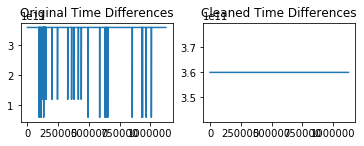

In [10]:
# remove any datapoints that are less than 6 minutes apart
cleaned = remove_extra_datapoints(data_indexed)

In [11]:
#Set the index as the time and change to datetime
#cleaned.set_index('time', inplace = True)
cleaned.index = pd.to_datetime(cleaned.index)
cleaned.head()

,primary,sigma,backup,verified,prediction
time,,,,,
2007-01-01 00:00:00,-0.074,0.009,-0.062,-0.074,-0.081
2007-01-01 00:06:00,-0.057,0.004,-0.048,-0.057,-0.062
2007-01-01 00:12:00,-0.037,0.003,-0.029,-0.037,-0.043
2007-01-01 00:18:00,-0.014,0.006,-0.004,-0.014,-0.024
2007-01-01 00:24:00,0.010,0.007,0.018,0.010,-0.005


We need to add an optional step to add long-term corrections back into the primary (usually ~ 1cm) to avoid marking times where data was actually good, there was just a leveling offset later discovered. 

Optional if long-term offsets were later applied to the data (need a way to check this and include it in the input data files in the future) + means to add to primary to correct
For AC the offsets are from: 
 2013-05-17 15:36 to 2013-11-07 19:06 of +0.012m
 2017-07-20 13:00 to 2017-12-07 15:30 of +0.011m
For Lewes the offsets are from:
 2011-04-27 13:42 to 2011-05-25 14:36 of +0.008m
 2017-07-10 19:42 to 2017-07-14 13:54 of -0.011m
For Boston the offsets are from:
 2015-06-11 16:30 to 2015-07-27 20:18 of +0.009m
 2016-09-13 20:12 to 2016-09-22 14:48 of +0.008m
None for Cape May or Portland

In [12]:
#Apply optional long term corrector at set time periods with set offsets
#AC
#offsetTimes=[('2013-05-17 15:36','2013-11-07 19:06'), ('2017-07-20 13:00','2017-12-07 15:30')]
#offsetValues = [0.012, 0.011]

#Lewes
#offsetTimes=[('2011-04-27 13:42', '2011-05-25 14:36'), ('2017-07-10 19:42', '2017-07-14 13:54')]
#offsetValues = [0.008, -0.011]

#Boston
#offsetTimes=[('2015-06-11 16:30', '2015-07-27 20:18'), ('2016-09-13 20:12', '2016-09-22 14:48')]
#offsetValues = [0.009, 0.008]

#Nantucket
offsetTimes=[('2016-09-19 17:30', '2017-01-11 15:12')]
offsetValues = [0.009]

cleaned = applyOffset(cleaned, offsetTimes, offsetValues)
cleaned


,primary,sigma,backup,verified,prediction
time,,,,,
2007-01-01 00:00:00,-0.074,0.009,-0.062,-0.074,-0.081
2007-01-01 00:06:00,-0.057,0.004,-0.048,-0.057,-0.062
2007-01-01 00:12:00,-0.037,0.003,-0.029,-0.037,-0.043
2007-01-01 00:18:00,-0.014,0.006,-0.004,-0.014,-0.024
2007-01-01 00:24:00,0.010,0.007,0.018,0.010,-0.005
...,...,...,...,...,...
2019-10-31 23:36:00,-0.127,0.008,-0.117,-0.127,-0.318
2019-10-31 23:42:00,-0.158,0.007,-0.149,-0.158,-0.348
2019-10-31 23:48:00,-0.183,0.007,-0.175,-0.183,-0.378


In [13]:
#Make sure the offset was applied correctly
cleaned.loc[offsetTimes[0][0]:offsetTimes[0][1]]

,primary,sigma,backup,verified,prediction
time,,,,,
2016-09-19 17:30:00,0.638,0.009,0.645,0.638,0.563
2016-09-19 17:36:00,0.662,0.007,0.645,0.662,0.580
2016-09-19 17:42:00,0.674,0.008,0.684,0.674,0.595
2016-09-19 17:48:00,0.705,0.007,0.713,0.705,0.609
2016-09-19 17:54:00,0.720,0.007,0.728,0.720,0.623
...,...,...,...,...,...
2017-01-11 14:48:00,0.706,0.003,0.701,0.706,0.659
2017-01-11 14:54:00,0.714,0.005,0.709,0.714,0.672
2017-01-11 15:00:00,0.737,0.003,0.730,0.737,0.683


In [14]:
#Lets add residual (primary - prediction)
cleaned['residual']=cleaned.loc[:,'primary']-cleaned.loc[:,'prediction']

#Lets calculate targets here (setting = if less than 2cm to avoid periods where processors filled for ease of use)
cleaned['targets'] = 1*( (cleaned.loc[:,'verified'] - cleaned.loc[:,'primary']).between(-.02, .02))
#Need to set any rows with NaNs in primary or verified as NaN
cleaned.loc[cleaned['primary'].isnull(),'targets'] =  np.nan
cleaned.loc[cleaned['verified'].isnull(),'targets'] =  np.nan


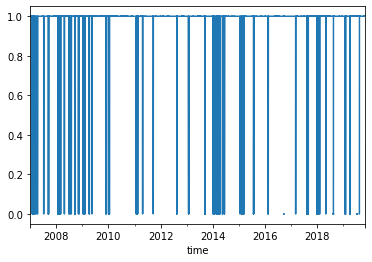

In [15]:
#cleaned.loc[offsetTimes[0][0]:offsetTimes[0][1],'targets'].plot()
cleaned['targets'].plot()
#cleaned

In [16]:
#save data, uses filename as base
import os
fid = os.path.basename(filenameIn)
fname,ext = os.path.splitext(fid)

#t_outfile = fname+'_Target'
#f_outfile = fname+'_Features'
c_outfile = fname+'_Cleaned'

#targets.to_pickle(t_outfile)
cleaned.to_pickle(c_outfile)
#features.to_pickle(f_outfile)